In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')

cuda:0 is available


In [39]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride = 1):
        super().__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels,self.out_channels, kernel_size=3, stride = stride, padding = 1, bias = False ),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Conv2d(self.out_channels,self.out_channels, kernel_size=3, stride = 1, padding = 1, bias = False ),
            nn.BatchNorm2d(self.out_channels)
        )

        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels,self.out_channels, kernel_size=1, stride = stride, bias = False ),
            nn.BatchNorm2d(self.out_channels)

            )

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)
        out = F.relu(x + out)
        return out


In [40]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.in_chnnels = 64
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = self._make_layer(64,num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(128,num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(256,num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(512,num_blocks[3], stride = 2)
        self.gap = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)


    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride]+[1]*(num_blocks -1)
        print(strides)
        layers = []
        for stride in strides:
            block = ResidualBlock(self.in_chnnels, out_channels, stride)
            layers.append(block)
            self.in_chnnels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out




In [41]:
def modeltype(model):
    if model == "resnet18":
        return ResNet([2,2,2,2])
    elif model == "resnet34":
        return ResNet([3,4,6,3])
        

In [51]:
summary(resnet, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
     ResidualBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [43]:
resnet = modeltype("resnet18").to(device)
print(resnet)
path = "./model/cifar_resnet.pth"

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [45]:
loss_ = []
n = len(trainloader)

for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_.append(running_loss / n)
    print('[%d] loss: %.3f'%(epoch+1, running_loss / n))

[1] loss: 1.361
[2] loss: 0.846
[3] loss: 0.625
[4] loss: 0.483
[5] loss: 0.369
[6] loss: 0.272
[7] loss: 0.191
[8] loss: 0.135
[9] loss: 0.104
[10] loss: 0.081
[11] loss: 0.072
[12] loss: 0.061
[13] loss: 0.051
[14] loss: 0.055
[15] loss: 0.044
[16] loss: 0.039
[17] loss: 0.037
[18] loss: 0.032
[19] loss: 0.035
[20] loss: 0.030
[21] loss: 0.027
[22] loss: 0.028
[23] loss: 0.026
[24] loss: 0.025
[25] loss: 0.024
[26] loss: 0.021
[27] loss: 0.022
[28] loss: 0.021


KeyboardInterrupt: 

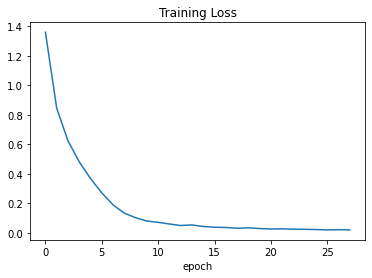

In [46]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [47]:
torch.save(resnet.state_dict(), path)

In [49]:
resnet = modeltype("resnet18").to(device)
resnet.load_state_dict(torch.load(path))

<All keys matched successfully>

In [50]:
correct = 0
total = 0
with torch.no_grad():
    resnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print("Test accuracy: %.2f %%"%(100 * correct / total) )

Test accuracy: 84.74 %
